1. Model "Random Forest"
źródło: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [1]:
import pandas as pd
# wczytanie danych i wyświetlenie 5 pięciu rekordów
features = pd.read_csv('temps.csv')
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [2]:
print('The shape of our features is:', features.shape)
features.describe()

The shape of our features is: (348, 12)


,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


In [3]:
# kodowanie '1 z n'
features = pd.get_dummies(features)
# wyświetl 5 pierwszych wierszy ostatnich 12 kolumn
features.iloc[:,5:].head(5)

,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,46.0,44,46,46,46,41,0,0,0,0,0,1,0


In [4]:
import numpy as np
# Labels to wartosci które chcemy przewidzieć
labels = np.array(features['actual'])
# usuwanie label z features
# axis 1 odnosi się do kolumn
features= features.drop('actual', axis = 1)
# zapisanie nazw kolumn na później
feature_list = list(features.columns)
# konwersja do array
features = np.array(features)

In [5]:
from sklearn.model_selection import train_test_split
# podział danych na treningowe i testowe
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (261, 17)
Training Labels Shape: (261,)
Testing Features Shape: (87, 17)
Testing Labels Shape: (87,)


In [6]:
# podstawowymi prognozami są średnie historyczne
baseline_preds = test_features[:, feature_list.index('average')]
# błędy poziomu podstawowego + średnia zaokrąglona wartość
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  5.06


In [7]:
# import modelu
from sklearn.ensemble import RandomForestRegressor
# inicjalizacja modelu z 1000 drzewami decyzyjnymi
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# trenowanie modelu na danych treningowych
rf.fit(train_features, train_labels);

In [8]:
# użycie metody 'forest's predict' na danych testowych
predictions = rf.predict(test_features)
# obliczenie błędów absolutnych
errors = abs(predictions - test_labels)
# print średniego błędu absolutnego (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.87 degrees.


In [9]:
# obliczenie procentowego mae (MAPE)
mape = 100 * (errors / test_labels)
# obliczenie i wyświetlenie dopasowania
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.93 %.


In [10]:
from sklearn.tree import export_graphviz
import pydot
# wyjęcie jednego drzewa z lasu
tree = rf.estimators_[5]

# eksport drzewa do pliku dot
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# tworzenie grafu przy pomocy pliku dot
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# zapisanie grafu do pliku png
graph.write_png('tree.png')

In [11]:
# ograniczenie głębokości drzewa do 3 poziomów
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# wyróżnienie małego drzewa
tree_small = rf_small.estimators_[5]
# zapis drzewa do pliku
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [12]:
# ważne cechy
importances = list(rf.feature_importances_)
# lista krotek z wartościami i cechami
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# sortowanie od najbardziej istotnych
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.66
Variable: average              Importance: 0.15
Variable: forecast_noaa        Importance: 0.05
Variable: forecast_acc         Importance: 0.03
Variable: day                  Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: forecast_under       Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


In [13]:
# nowy losowy las z tylko dwoma najważniejszymi wartościami
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# dwie najważniejsze cechy
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# trenowanie randomowego lasu
rf_most_important.fit(train_important, train_labels)
# prognozy i ustalenie błędu
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# wyświetlanie metryk performance'u
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.92 degrees.
Accuracy: 93.76 %.


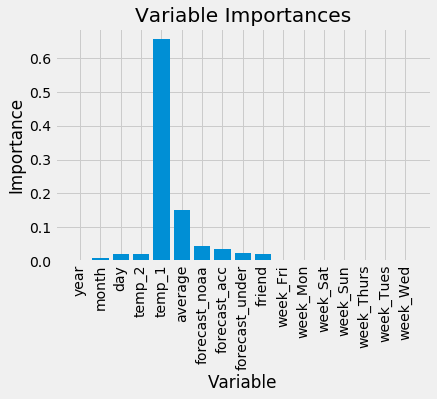

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
# style
plt.style.use('fivethirtyeight')
# lista lokacji x do wykresów
x_values = list(range(len(importances)))
# wykres słupkowy
plt.bar(x_values, importances, orientation = 'vertical')

plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

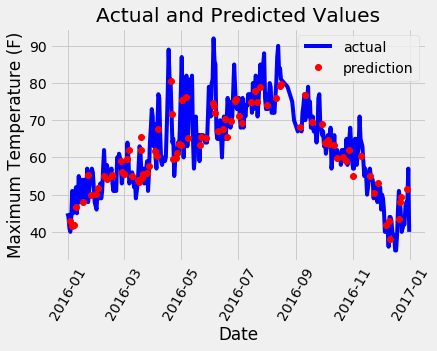

In [15]:
import datetime
# daty danych treningowych
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]
# konwersja do obiektów datetime
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
# dataframe z prawdziwymi wartościami i datami
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})
# daty przewidywane
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]
# kolumny dat
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# konwersja do obiektów datetime
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
#dataframe z wartościami i datami
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
# wykres prawdziwych danych
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# wykres przewidywanych danych
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# etykiety grafów
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

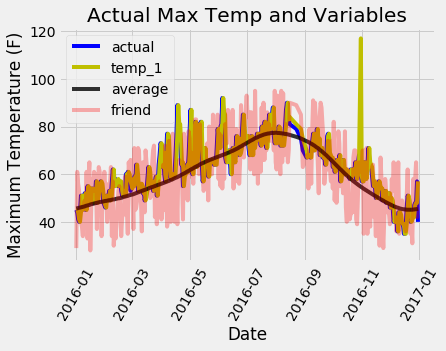

In [17]:
# dopasowanie danych dla wykresów
true_data['temp_1'] = features[:, feature_list.index('temp_1')]
true_data['average'] = features[:, feature_list.index('average')]
true_data['friend'] = features[:, feature_list.index('friend')]
# wykres wszystkich danych jako linii
plt.plot(true_data['date'], true_data['actual'], 'b-', label  = 'actual', alpha = 1.0)
plt.plot(true_data['date'], true_data['temp_1'], 'y-', label  = 'temp_1', alpha = 1.0)
plt.plot(true_data['date'], true_data['average'], 'k-', label = 'average', alpha = 0.8)
plt.plot(true_data['date'], true_data['friend'], 'r-', label = 'friend', alpha = 0.3)
# formatowanie wykresu
plt.legend(); plt.xticks(rotation = '60');
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');

2. Przekształcenie modelu

The shape of our features is: (348, 12)
Training Features Shape: (295, 17)
Training Labels Shape: (295,)
Testing Features Shape: (53, 17)
Testing Labels Shape: (53,)
Average baseline error:  5.69
Mean Absolute Error: 4.08 degrees.
Accuracy: 93.73 %.
Variable: temp_1               Importance: 0.51
Variable: average              Importance: 0.28
Variable: forecast_acc         Importance: 0.08
Variable: forecast_noaa        Importance: 0.03
Variable: day                  Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: forecast_under       Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Impor

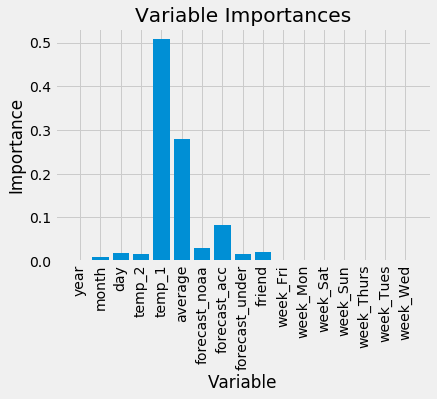

In [18]:
# wczytanie danych i wyświetlenie 5 pięciu rekordów
features = pd.read_csv('temps.csv')
features.head(5)

print('The shape of our features is:', features.shape)
features.describe()

# kodowanie '1 z n'
features = pd.get_dummies(features)
# wyświetl 5 pierwszych wierszy ostatnich 12 kolumn
features.iloc[:,5:].head(5)

# Labels to wartosci które chcemy przewidzieć
labels = np.array(features['actual'])
# usuwanie label z features
# axis 1 odnosi się do kolumn
features= features.drop('actual', axis = 1)
# zapisanie nazw kolumn na później
feature_list = list(features.columns)
# konwersja do array
features = np.array(features)

# podział danych na treningowe i testowe
# 1 zmiana - zmniejszenie zbioru testowego
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.15, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

# podstawowymi prognozami są średnie historyczne
baseline_preds = test_features[:, feature_list.index('average')]
# błędy poziomu podstawowego + średnia zaokrąglona wartość
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

# 2 zmiana - inicjalizacja modelu z 2000 drzew decyzyjnych
rf = RandomForestRegressor(n_estimators = 2000, random_state = 42)
# trenowanie modelu na danych treningowych
rf.fit(train_features, train_labels);

# użycie metody 'forest's predict' na danych testowych
predictions = rf.predict(test_features)
# obliczenie błędów absolutnych
errors = abs(predictions - test_labels)
# print średniego błędu absolutnego (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# obliczenie procentowego mae (MAPE)
mape = 100 * (errors / test_labels)
# obliczenie i wyświetlenie dopasowania
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# wyjęcie jednego drzewa z lasu
# 3 zmiana
tree = rf.estimators_[1]

# eksport drzewa do pliku dot
export_graphviz(tree, out_file = 'tree2.dot', feature_names = feature_list, rounded = True, precision = 1)
# tworzenie grafu przy pomocy pliku dot
(graph, ) = pydot.graph_from_dot_file('tree2.dot')
# zapisanie grafu do pliku png
graph.write_png('tree2.png')

# 4 zmiana - ograniczenie głębokości drzewa do 5 poziomów
rf_small = RandomForestRegressor(n_estimators=20, max_depth = 5)
rf_small.fit(train_features, train_labels)
# wyróżnienie małego drzewa
tree_small = rf_small.estimators_[1]
# zapis drzewa do pliku
export_graphviz(tree_small, out_file = 'small_tree2.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree2.dot')
graph.write_png('small_tree2.png');

# ważne cechy
importances = list(rf.feature_importances_)
# lista krotek z wartościami i cechami
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# sortowanie od najbardziej istotnych
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# 5 zmiana - bierzemy 3 z najważniejszych cech
# nowy losowy las z tylko trzema najważniejszymi wartościami
rf_most_important = RandomForestRegressor(n_estimators= 2000, random_state=42)
# trzy najważniejsze cechy
important_indices = [feature_list.index('temp_1'), feature_list.index('average'), feature_list.index('forecast_acc')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# trenowanie randomowego lasu
rf_most_important.fit(train_important, train_labels)
# prognozy i ustalenie błędu
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# wyświetlanie metryk performance'u
print('Mean Absolute Error Of 3 indicates:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

%matplotlib inline
# style
plt.style.use('fivethirtyeight')
# lista lokacji x do wykresów
x_values = list(range(len(importances)))
# wykres słupkowy
plt.bar(x_values, importances, orientation = 'vertical')

plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');


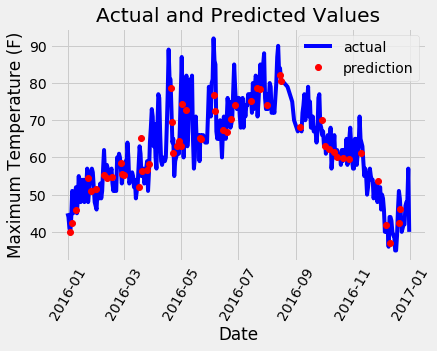

In [19]:
# daty danych treningowych
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]
# konwersja do obiektów datetime
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
# dataframe z prawdziwymi wartościami i datami
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})
# daty przewidywane
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]
# kolumny dat
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# konwersja do obiektów datetime
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
#dataframe z wartościami i datami
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
# wykres prawdziwych danych
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# wykres przewidywanych danych
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# etykiety grafów
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');


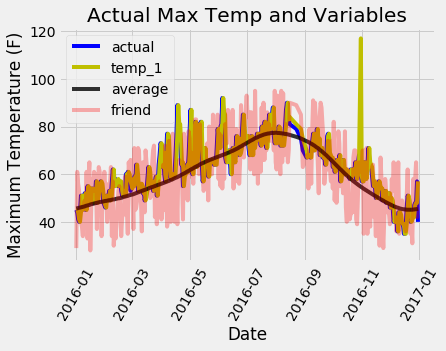

In [20]:
# dopasowanie danych dla wykresów
true_data['temp_1'] = features[:, feature_list.index('temp_1')]
true_data['average'] = features[:, feature_list.index('average')]
true_data['friend'] = features[:, feature_list.index('friend')]
# wykres wszystkich danych jako linii
plt.plot(true_data['date'], true_data['actual'], 'b-', label  = 'actual', alpha = 1.0)
plt.plot(true_data['date'], true_data['temp_1'], 'y-', label  = 'temp_1', alpha = 1.0)
plt.plot(true_data['date'], true_data['average'], 'k-', label = 'average', alpha = 0.8)
plt.plot(true_data['date'], true_data['friend'], 'r-', label = 'friend', alpha = 0.3)
# formatowanie wykresu
plt.legend(); plt.xticks(rotation = '60');
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');

3. Wnioski i podsumowanie

Model służy do przewidywania temperatury na podstawie danych z jednego roku. Mamy dostęp do rocznych maksymalnych temperatur historycznych, temperatur z poprzednich dwóch dni oraz szacunków znajomego, który zawsze twierdzi, że wie wszystko o pogodzie.

Zmiany w modelu dotyczyły zmniejszenie wielkości zbioru testowego z 25 do 15%, dwukrotnego zwiększenia liczby drzew decyzyjnych, wyboru pojedynczego drzewa do analizy, maksymalnej głębokości drzewa i analizy modelu na podstawie 3 cech zamiast 2. Wyniki nie zmieniły się w znaczny sposób:
1) miara dopasowania i błąd średni

    pierwotny model:
Average baseline error:  5.06
Mean Absolute Error: 3.87 degrees.
Accuracy: 93.93 %.

    model udoskonalony na podstawie dwóch zmiennych:
Mean Absolute Error: 3.92 degrees.
Accuracy: 93.76 %.

    model ze zmianami:
Average baseline error:  5.69
Mean Absolute Error: 4.08 degrees.
Accuracy: 93.73 %.

Mean Absolute Error Of 3 indicates: 4.1 degrees.
Accuracy: 93.67 %.

Dla modelu z wprowadzonymi zmianami po zastosowaniu mniejszego zbioru testowego i bardziej szczegółowych drzew wynik jest przybliżony.

2) przewidywanie na podstawie zmiennych
Ważności zwrócone w Skicit-learn reprezentują, o ile uwzględnienie określonej zmiennej poprawia przewidywanie. Dla modelu oryginalnego poszczególne wartości wynosiły:

Variable: temp_1               Importance: 0.66
Variable: average              Importance: 0.15
Variable: forecast_noaa        Importance: 0.05
Variable: forecast_acc         Importance: 0.03
Variable: day                  Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: forecast_under       Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0

dla modelu zmienionego:
Variable: temp_1               Importance: 0.51
Variable: average              Importance: 0.28
Variable: forecast_acc         Importance: 0.08
Variable: forecast_noaa        Importance: 0.03
Variable: day                  Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: forecast_under       Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0

Zmiany są widoczne, kolejność różni się na pozycjach 3 i 4.
3) widoczna różnica dla 'small_tree.png'
4) wykres danych rzeczywistych i przewidywanych
Wykresy wyglądają identycznie, zmiany nie miały więc dużego wpływu na uczenie modelu. Widoczny pik w okolicach 2016-11 odróżnia model od tego zaprezentowanego w artykule, udostępnione dane mogą się więc różnić od tych wykorzystanych podczas pracy autora.